In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

In [2]:
def haversine(coord1, coord2):
    R = 6371
    lat1, lon1 = map(float, coord1.strip("()").split(","))
    lat2, lon2 = map(float, coord2.strip("()").split(","))
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [3]:
df=pd.read_csv('Food_Delivery_Time_Prediction.csv')
df.dropna()
df_encoded = pd.get_dummies(df,columns=['Weather_Conditions','Traffic_Conditions','Vehicle_Type','Order_Priority'])
df_encoded.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,...,Weather_Conditions_Sunny,Traffic_Conditions_High,Traffic_Conditions_Low,Traffic_Conditions_Medium,Vehicle_Type_Bicycle,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_High,Order_Priority_Low,Order_Priority_Medium
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,4,Afternoon,4.1,3.0,26.22,1321.10,...,False,False,False,True,False,False,True,False,False,True
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,8,Night,4.5,4.2,62.61,152.21,...,False,False,False,True,False,False,True,False,True,False
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,9,Night,3.3,3.4,48.43,1644.38,...,False,False,False,True,False,True,False,True,False,False
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,2,Evening,3.2,3.7,111.63,541.25,...,False,False,True,False,False,True,False,False,False,True
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,6,Night,3.5,2.8,32.38,619.81,...,False,True,False,False,False,True,False,False,True,False


In [4]:
df_scaled = df_encoded.copy()
df_scaled['GDistance'] = df_scaled.apply(lambda row: haversine(row['Customer_Location'], row['Restaurant_Location']),axis=1)
df_scaled['Delivery_Status'] = df_scaled['Delivery_Time'].apply(lambda x: 'Fast' if x <= df_scaled['Delivery_Time'].quantile(0.75) else 'Delayed')
df_scaled['Delivery_Status'] = df_scaled['Delivery_Status'].map({'Fast': 0, 'Delayed': 1})

scaler = pp.StandardScaler()
columnsToScale = ['Distance','GDistance','Delivery_Time','Order_Cost']
df_scaled[columnsToScale] = scaler.fit_transform(df_scaled[columnsToScale])
df_scaled.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Delivery_Person_Experience,Order_Time,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,...,Traffic_Conditions_Low,Traffic_Conditions_Medium,Vehicle_Type_Bicycle,Vehicle_Type_Bike,Vehicle_Type_Car,Order_Priority_High,Order_Priority_Low,Order_Priority_Medium,GDistance,Delivery_Status
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",-1.454738,4,Afternoon,4.1,3.0,-1.487932,0.501852,...,False,True,False,False,True,False,False,True,0.641395,0
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",1.439192,8,Night,4.5,4.2,-0.264987,-1.634294,...,False,True,False,False,True,False,True,False,1.632526,0
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",-0.666417,9,Night,3.3,3.4,-0.741529,1.092646,...,False,True,False,True,False,True,False,False,-0.471227,0
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",0.335835,2,Evening,3.2,3.7,1.382411,-0.923323,...,True,False,False,True,False,False,False,True,-0.791930,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",-0.700119,6,Night,3.5,2.8,-1.280915,-0.779755,...,False,False,False,True,False,False,True,False,0.756045,0


In [5]:
bayes = GaussianNB()
x = pd.get_dummies(df[['Traffic_Conditions','Weather_Conditions','Order_Priority','Vehicle_Type','Order_Time']],drop_first=True).merge(df_scaled[['GDistance','Delivery_Person_Experience']],left_index=True,right_index=True)
y = df_scaled['Delivery_Status']
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.2)
bayes.fit(x_train,y_train)
y_pred1 = bayes.predict(x_test)

0.65
0.0
0.0
0.0


<Axes: >

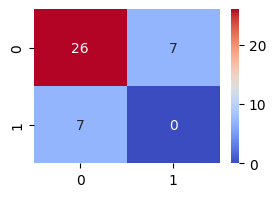

In [6]:
print(accuracy_score(y_test,y_pred1))
print(precision_score(y_test,y_pred1))
print(recall_score(y_test,y_pred1))
print(f1_score(y_test,y_pred1))
plt.figure(figsize=(3,2))
sb.heatmap(confusion_matrix(y_test,y_pred1),annot=True,cmap='coolwarm')

In [7]:
x = pd.get_dummies(df[['Traffic_Conditions','Weather_Conditions','Order_Priority','Vehicle_Type','Order_Time']],drop_first=True).merge(df_scaled[['GDistance','Delivery_Person_Experience']],left_index=True,right_index=True)
y = df_scaled['Delivery_Status']
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.2,random_state=42)

accuracy = 0
k = 0
for i in range(1,len(x_train)//2,2):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(x_train,y_train)
  y_pred = knn.predict(x_test)
  if accuracy_score(y_test,y_pred) > accuracy:
    accuracy = accuracy_score(y_test,y_pred)
    k = i

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x_train,y_train)
y_pred2 = knn.predict(x_test)

0.85
0.6666666666666666
0.5
0.5714285714285714


<Axes: >

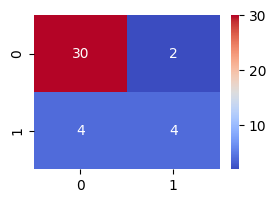

In [8]:
print(accuracy_score(y_test,y_pred2))
print(precision_score(y_test,y_pred2))
print(recall_score(y_test,y_pred2))
print(f1_score(y_test,y_pred2))
plt.figure(figsize=(3,2))
sb.heatmap(confusion_matrix(y_test,y_pred2),annot=True,cmap='coolwarm')

In [9]:
x = pd.get_dummies(df[['Traffic_Conditions','Weather_Conditions','Order_Priority','Vehicle_Type','Order_Time']],drop_first=True).merge(df_scaled[['GDistance','Delivery_Person_Experience']],left_index=True,right_index=True)
y = df_scaled['Delivery_Status']
x_train,x_test,y_train,y_test = tts(x,y,test_size=0.2,random_state=42)

accuracy = 0
depth = 0
split = 0
for i in range(2,21):
  for j in [2,5,10,20,50]:
    dtree = DecisionTreeClassifier(max_depth=i,min_samples_split=j)
    dtree.fit(x_train,y_train)
    y_pred = dtree.predict(x_test)
    if accuracy_score(y_test,y_pred) > accuracy:
      accuracy = accuracy_score(y_test,y_pred)
      depth = i
      split = j

dtree = DecisionTreeClassifier(max_depth=depth,min_samples_split=split)
dtree.fit(x_train,y_train)
y_pred3 = dtree.predict(x_test)

0.775
0.0
0.0
0.0


<Axes: >

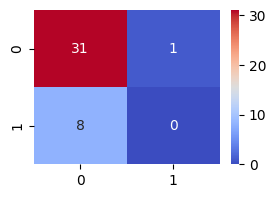

In [10]:
print(accuracy_score(y_test,y_pred3))
print(precision_score(y_test,y_pred3))
print(recall_score(y_test,y_pred3))
print(f1_score(y_test,y_pred3))
plt.figure(figsize=(3,2))
sb.heatmap(confusion_matrix(y_test,y_pred3),annot=True,cmap='coolwarm')

In this assignment Naives Bayes, KNN and Decision Tree is used to estimate the classification of delivery status using Traffic condition,Weather condition, Order Priority, Vehicle Type, Order Time, Geographic Distance and Delivery person experience. The scores achieved by the models are;

## Naives Bayes
1. Accuracy Score: 0.725
2. Precision Score: 0.5
3. Recall Score: 0.09090909090909091
4. F1 Score: 0.15384615384615385

## K Nearest Neighbor
1. Accuracy Score: 0.85
2. Precision Score: 0.66666666666666666
3. Recall Score: 0.5
4. F1 Score: 0.5714285714285714

## Decision Tree
1. Accuracy Score: 0.8
2. Precision Score: 0.5
3. Recall Score: 0.125
4. F1 Score: 0.2

In my models, all of them have very good scores, with K Nearest Neighbor conquering the first position. Tuning for K in KNN and depth,split in Decision Tree made them very much accurate.